# モデルを作る

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [49]:
tmp = torch.randn(3, 5, 30)
tmp.shape

torch.Size([3, 5, 30])

In [50]:
lstm = nn.LSTM(30, 10, num_layers=3, dropout=0.3, bidirectional=True, batch_first=True)
tmp, _ = lstm(tmp)
tmp.shape

torch.Size([3, 5, 20])

In [51]:
ln = nn.Linear(20, 1)
tmp = ln(tmp)
tmp.shape

torch.Size([3, 5, 1])

In [52]:
tmp

tensor([[[-0.2226],
         [-0.2422],
         [-0.2399],
         [-0.2599],
         [-0.2430]],

        [[-0.2154],
         [-0.2285],
         [-0.2436],
         [-0.2564],
         [-0.2567]],

        [[-0.2085],
         [-0.2232],
         [-0.2387],
         [-0.2456],
         [-0.2527]]], grad_fn=<AddBackward0>)

In [53]:
tmp = F.softmax(tmp, dim=1)
tmp.shape

torch.Size([3, 5, 1])

In [54]:
tmp

tensor([[[0.2038],
         [0.1999],
         [0.2003],
         [0.1963],
         [0.1997]],

        [[0.2050],
         [0.2023],
         [0.1993],
         [0.1967],
         [0.1967]],

        [[0.2051],
         [0.2021],
         [0.1990],
         [0.1976],
         [0.1962]]], grad_fn=<SoftmaxBackward>)

In [55]:
tmp.sum(dim=1)

tensor([[1.],
        [1.],
        [1.]], grad_fn=<SumBackward1>)

In [48]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self):
        self.X = torch.randn(15, 10, 5)
        self.y = torch.randn(10)
        self.num_data = 10

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        x = self.X[i]
        y = self.y[i]
        return x, y
dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=3)
for data in dataloader:
    print(data[0].shape)
    break

torch.Size([3, 10, 5])


In [61]:
p = torch.tensor([[1,2,3],[4,5,6]])
b = torch.tensor([[10],[100]])
p*b

tensor([[ 10,  20,  30],
        [400, 500, 600]])

In [66]:
biln = nn.Bilinear(10, 10, 1)
a = torch.randn(5, 10)
b = torch.randn(5, 10)
biln(a, b)

tensor([[-0.3270],
        [ 1.1937],
        [ 1.2751],
        [ 2.1794],
        [-0.5897]], grad_fn=<AddBackward0>)

In [67]:
tmp = torch.randn(3,3)
tmp.sum(dim=0).shape

torch.Size([3])

In [69]:
a = torch.randn(2,5)
b = torch.randn(5)
a@b

tensor([-1.8941,  2.6537])

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DocReader(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, dropout):
        super(DocReader, self).__init__()
        self.P_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_AccumWeight = nn.Linear(hidden_dim*2, 1, bias=False)
        self.Start_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)
        self.End_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)

    def forward(self, p, q):
        p, _ = self.P_Enc(p)
        q, _ = self.Q_Enc(q)
        b = F.softmax(self.Q_AccumWeight(q), dim=1)
        q = (q*b).sum(dim=1)
        start_proba = F.softmax(torch.einsum('bnm,bm->bn', self.Start_Pred(p), q), dim=1)
        end_proba = F.softmax(torch.einsum('bnm,bm->bn', self.End_Pred(p), q), dim=1)
        return start_proba, end_proba

In [97]:
model = DocReader(300, 128, 3, 0.3)

In [98]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self):
        self.P = torch.randn(15, 10, 300)
        self.Q = torch.randn(15, 5, 300)
        self.num_data = 15

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        p = self.P[i]
        q = self.Q[i]
        return p, q
dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=3)

In [99]:
for p, q in dataloader:
    a,b = model(p, q)
    break

torch.Size([3, 5, 1])
tensor([[0.5970],
        [0.6031],
        [0.6011],
        [0.6004],
        [0.5984]], grad_fn=<SumBackward1>)
tensor([[1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SumBackward1>)
tensor([[0.1992, 0.2006, 0.2002, 0.2008, 0.1992],
        [0.2000, 0.2008, 0.2005, 0.1996, 0.1992],
        [0.1978, 0.2017, 0.2004, 0.2001, 0.2000]], grad_fn=<SumBackward1>)


torch.Size([3, 10])
tensor([0.3015, 0.3007, 0.3003, 0.3015, 0.3001, 0.2997, 0.3000, 0.3002, 0.2982,
        0.2978], grad_fn=<SumBackward1>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


In [91]:
tmp = torch.tensor([[1,2,3],[4,5,6]])
tmp.sum(dim=0, keepdim=True)

tensor([[5, 7, 9]])

In [60]:
a = torch.randn(2,3)
b = torch.randn(3)
torch.mm(a, b)

RuntimeError: mat2 must be a matrix

# データの準備

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
import gensim
import json
torch.manual_seed(0)
w2v_dim = 300
w2v_undebiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    train_dict = json.load(f)
with open('data/squad1.1/dev-v1.1.json', encoding='utf-8') as f:
    test_dict = json.load(f)

In [73]:
max_words_context = 0
max_words_question = 0
train_idxs = []
for i, title in enumerate(train_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        num_words_context = len(word_tokenize(paragraph['context'].lower()))
        if num_words_context > max_words_context:
            max_words_context = num_words_context
        for k, qa in enumerate(paragraph['qas']):
            train_idxs.append(str(i)+'-'+str(j)+'-'+str(k))
            num_words_question = len(word_tokenize(qa['question'].lower()))
            if num_words_question > max_words_question:
                max_words_question = num_words_question
test_idxs = []
for i, title in enumerate(test_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        num_words_context = len(word_tokenize(paragraph['context'].lower()))
        if num_words_context > max_words_context:
            max_words_context = num_words_context
        for k, qa in enumerate(paragraph['qas']):
            test_idxs.append(str(i)+'-'+str(j)+'-'+str(k))
            num_words_question = len(word_tokenize(qa['question'].lower()))
            if num_words_question > max_words_question:
                max_words_question = num_words_question

In [74]:
print(max_words_context)
print(max_words_question)

766
60


In [80]:
class MyDataset(Dataset):
    def __init__(self,
                 data_dict, index_lst,
                 max_words_context, max_words_question, w2v_dim,
                 w2v_model,
                 isTrain):
        self.data_dict = data_dict
        self.index_lst = index_lst
        self.num_data = len(index_lst)
        self.max_words_context = max_words_context
        self.max_words_question = max_words_question
        self.w2v_dim = w2v_dim
        self.w2v_model = w2v_model
        self.isTrain = isTrain

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        idx = list(map(lambda x: int(x), self.index_lst[i].split('-')))
        context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
        context = word_tokenize(context.lower())
        context_emb = torch.zeros(self.max_words_context, self.w2v_dim)
        for i, word in enumerate(context):
            if word in self.w2v_model.key_to_index:
                context_emb[i] += self.w2v_model[word]
        question = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['question']
        question = word_tokenize(question.lower())
        question_emb = torch.zeros(self.max_words_question, self.w2v_dim)
        for i, word in enumerate(question):
            if word in self.w2v_model.key_to_index:
                question_emb[i] += self.w2v_model[word]
        answers = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['answers']
        if self.isTrain:
            answer = answers[0]
            context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
            context = context[:answer['answer_start']] + ' start_point ' + context[answer['answer_start']:]
            context = word_tokenize(context.lower())
            start_idx = context.index('start_point')
            end_idx = start_idx + len(word_tokenize(answer['text'])) - 1
        else:
            start_idx = []
            end_idx = []
            context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
            for answer in answers:
                context_ = context[:answer['answer_start']] + ' start_point ' + context[answer['answer_start']:]
                context_ = word_tokenize(context_.lower())
                start_idx.append(context_.index('start_point'))
                end_idx.append(start_idx[-1] + len(word_tokenize(answer['text'])) - 1)
        return context_emb, question_emb, start_idx, end_idx

train_set = MyDataset(train_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased, True)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_set = MyDataset(test_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased, False)
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [76]:
print(test_dict['data'][0]['paragraphs'][1]['context'])
print(test_dict['data'][0]['paragraphs'][1]['qas'][1]['question'])
print(test_dict['data'][0]['paragraphs'][1]['qas'][1]['answers'])

The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl.
How many appearances have the Denver Broncos made in the Super Bowl?
[{'answer_start': 467, 'text': '8'}, {'answer_start': 601, 'text': 'eight'}, {'answer_start': 601, 'text': 'eight'}]


In [82]:
word_tokenize('This  is a pen.')

['This', 'is', 'a', 'pen', '.']

In [81]:
for Xc, Xq, ys, ye in test_loader:
    print(Xc.shape)
    print(Xq.shape)
    print(ys)
    print(ye)
    break

RuntimeError: each element in list of batch should be of equal size

In [15]:
print(train_dict.keys())
print(type(train_dict['data']), len(train_dict['data']))
print(train_dict['data'][0].keys())
print(type(train_dict['data'][0]['paragraphs']), len(train_dict['data'][0]['paragraphs']))
print(train_dict['data'][0]['paragraphs'][0].keys())
print(type(train_dict['data'][0]['paragraphs'][0]['qas']), len(train_dict['data'][0]['paragraphs'][0]['qas']))
print(train_dict['data'][0]['paragraphs'][0]['qas'][0].keys())
print(train_dict['data'][0]['paragraphs'][0]['qas'][0])
print(train_dict['data'][0]['paragraphs'][0]['context'])

dict_keys(['data', 'version'])
<class 'list'> 442
dict_keys(['title', 'paragraphs'])
<class 'list'> 55
dict_keys(['context', 'qas'])
<class 'list'> 5
dict_keys(['answers', 'question', 'id'])
{'answers': [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}], 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'id': '5733be284776f41900661182'}
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connec

In [113]:
print(test_dict.keys())
print(type(test_dict['data']), len(test_dict['data']))
print(test_dict['data'][0].keys())
print(type(test_dict['data'][0]['paragraphs']), len(test_dict['data'][0]['paragraphs']))
print(test_dict['data'][0]['paragraphs'][0].keys())
print(type(test_dict['data'][0]['paragraphs'][0]['qas']), len(test_dict['data'][0]['paragraphs'][0]['qas']))
print(test_dict['data'][0]['paragraphs'][0]['qas'][0].keys())
print(test_dict['data'][0]['paragraphs'][0]['qas'][0])
print(test_dict['data'][0]['paragraphs'][0]['context'])

dict_keys(['data', 'version'])
<class 'list'> 48
dict_keys(['title', 'paragraphs'])
<class 'list'> 54
dict_keys(['context', 'qas'])
<class 'list'> 30
dict_keys(['answers', 'question', 'id'])
{'answers': [{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}], 'question': 'Which NFL team represented the AFC at Super Bowl 50?', 'id': '56be4db0acb8001400a502ec'}
Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, 

In [143]:
# テストデータだけ複数答えがある→CrossEntropyで学習しても大丈夫
index_lst = []
for i, title in enumerate(train_data['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        for k, qa in enumerate(paragraph['qas']):
            index_lst.append(str(i)+'-'+str(j)+'-'+str(k))
count = 0
for i in range(len(index_lst)):
    idx = list(map(lambda x: int(x), index_lst[i].split('-')))
    answers = train_data['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['answers']
    if len(answers) > 1:
#        print(answers)
        count += 1
print(count)
print(len(index_lst))
index_lst = []
for i, title in enumerate(test_data['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        for k, qa in enumerate(paragraph['qas']):
            index_lst.append(str(i)+'-'+str(j)+'-'+str(k))
count = 0
for i in range(len(index_lst)):
    idx = list(map(lambda x: int(x), index_lst[i].split('-')))
    answers = test_data['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['answers']
    if len(answers) > 1:
#        print(answers)
        count += 1
print(count)
print(len(index_lst))

0
87599
10567
10570


In [79]:
count = 0
for i, title in enumerate(test_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        for k, qa in enumerate(paragraph['qas']):
            print(test_dict['data'][i]['paragraphs'][j]['context'])
            print(test_dict['data'][i]['paragraphs'][j]['qas'][k]['question'])
            print(test_dict['data'][i]['paragraphs'][j]['qas'][k]['answers'])
            print()
            count += 1
            if count > 10:
                break
        if count > 10:
            break
    if count > 10:
        break

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Which NFL team represented the AFC at Super Bowl 50?
[{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}]

Super Bowl 50 was an A

# 実験

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import gensim
import json
import matplotlib.pyplot as plt

C:\Users\gabriel\anaconda3\envs\torch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
isModeling = True

# data loaderのため
torch.manual_seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)

w2v_undebiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
w2v_debiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
w2v_dim = 300

In [3]:
with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    data_dict = json.load(f)

max_words_context = 0
max_words_question = 0
data_idxs = []
for i, title in enumerate(data_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        num_words_context = len(word_tokenize(paragraph['context'].lower()))
        if num_words_context > max_words_context:
            max_words_context = num_words_context
        for k, qa in enumerate(paragraph['qas']):
            data_idxs.append(str(i)+'-'+str(j)+'-'+str(k))
            num_words_question = len(word_tokenize(qa['question'].lower()))
            if num_words_question > max_words_question:
                max_words_question = num_words_question
train_idxs, test_idxs = train_test_split(data_idxs, test_size=0.2, random_state=0)

In [5]:
print(len(train_idxs))
print(len(test_idxs))
print(len(train_idxs) / 292)
print(len(test_idxs) / 292)

70079
17520
239.99657534246575
60.0


In [2]:
class MyDataset(Dataset):
    def __init__(self,
                 data_dict, index_lst,
                 max_words_context, max_words_question, w2v_dim,
                 w2v_model):
        self.data_dict = data_dict
        self.index_lst = index_lst
        self.num_data = len(index_lst)
        self.max_words_context = max_words_context
        self.max_words_question = max_words_question
        self.w2v_dim = w2v_dim
        self.w2v_model = w2v_model

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        idx = list(map(lambda x: int(x), self.index_lst[i].split('-')))
        context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
        context = word_tokenize(context.lower())
        context_emb = torch.zeros(self.max_words_context, self.w2v_dim)
        for i, word in enumerate(context):
            if word in self.w2v_model.key_to_index:
                context_emb[i] += self.w2v_model[word]
        question = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['question']
        question = word_tokenize(question.lower())
        question_emb = torch.zeros(self.max_words_question, self.w2v_dim)
        for i, word in enumerate(question):
            if word in self.w2v_model.key_to_index:
                question_emb[i] += self.w2v_model[word]
        answer = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['answers'][0]
        context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
        context = context[:answer['answer_start']] + ' _start_point_ ' + context[answer['answer_start']:]
        context = word_tokenize(context.lower())
        start_idx = context.index('_start_point_')
        end_idx = start_idx + len(word_tokenize(answer['text'])) - 1
        return context_emb, question_emb, start_idx, end_idx

udb_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
udb_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
db_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)
db_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)

device: cuda


In [5]:
# 入力：文書と質問(バッチ数x単語数x分散表現の次元)
# 出力：文書の中で答えと予想される範囲の始まりと終わりの分布(バッチ数x単語数)
class DocReader(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, dropout):
        super(DocReader, self).__init__()
        self.P_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_AccumWeight = nn.Linear(hidden_dim*2, 1, bias=False)
        self.Start_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)
        self.End_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)

    def forward(self, p, q):
        p, _ = self.P_Enc(p)
        q, _ = self.Q_Enc(q)
        b = F.softmax(self.Q_AccumWeight(q), dim=1)
        q = (q*b).sum(dim=1)
        pred_start = torch.einsum('bnm,bm->bn', self.Start_Pred(p), q)
        pred_end = torch.einsum('bnm,bm->bn', self.End_Pred(p), q)
        return pred_start, pred_end

num_epoch = 10
num_experiment = 100
LSTM_hidden_dim = 128
LSTM_num_layer = 3
dropout_rate = 0.3
lr = 0.1

def eval_exact_match(pred_start, pred_end, y_start, y_end):
    pred_start = pred_start.max(dim=1).indices
    pred_end = pred_end.max(dim=1).indices
    match = torch.logical_and(pred_start==y_start, pred_end==y_end)
    return match.sum() / len(match)

def eval_f1(pred_start, pred_end, y_start, y_end):
    pred_start = pred_start.max(dim=1).indices
    pred_end = pred_end.max(dim=1).indices
    start_diff = pred_start - y_start
    start_diff = torch.where(start_diff > 0, start_diff, 0)
    end_diff = y_end - pred_end
    end_diff = torch.where(end_diff > 0, end_diff, 0)
    TP = (y_end - y_start + 1 - start_diff - end_diff).double()
    TP = torch.where(TP > 0, TP, 1e-10) # TP=0だとf1がnanになる
    recall = TP / (y_end - y_start + 1)
    pred_diff = pred_end - pred_start
    pred_diff = torch.where(pred_diff > 0, pred_diff, 0)
    precision = TP / (pred_diff + 1)
#     precision = TP / (pred_end - pred_start + 1)
    f1 = 2*recall*precision / (recall + precision)
#     if torch.any(torch.logical_or(f1.isnan(), f1.isinf())):
#         print('recall:', recall)
#         print('precision:', precision)
    return f1.mean()

def train(isModeling, train_loader, test_loader, representation):
    if isModeling:
        num_experiment = 1
    else:
        em_scores = []
        f1_scores = []
        preds = []
    for experiment in range(num_experiment):
        # modelの初期値のため
        torch.manual_seed(experiment)
        model = DocReader(w2v_dim, LSTM_hidden_dim, LSTM_num_layer, dropout_rate).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

        train_loss_log = []
        eval_loss_log = []
        eval_em_log = []
        eval_f1_log = []
        for epoch in range(num_epoch):
            model.train()
            train_loss = 0
            for X_context, X_question, y_start, y_end in train_loader:
                X_context = X_context.to(device)
                X_question = X_question.to(device)
                y_start = y_start.to(device)
                y_end = y_end.to(device)
                pred_start, pred_end = model(X_context, X_question)
                loss = loss_fn(pred_start, y_start) + loss_fn(pred_end, y_end)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss*len(y_start)
            train_loss /= len(train_idxs)
            train_loss_log.append(train_loss.cpu().item())

            model.eval()
            eval_loss = 0
            em_total = 0
            f1_total = 0
            with torch.no_grad():
                for X_context, X_question, y_start, y_end in test_loader:
                    X_context = X_context.to(device)
                    X_question = X_question.to(device)
                    y_start = y_start.to(device)
                    y_end = y_end.to(device)
                    pred_start, pred_end = model(X_context, X_question)
                    loss = loss_fn(pred_start, y_start) + loss_fn(pred_end, y_end)
                    eval_loss += loss
                    em = eval_exact_match(pred_start, pred_end, y_start, y_end)
                    em_total += em
                    f1 = eval_f1(pred_start, pred_end, y_start, y_end)
                    f1_total += f1
                eval_loss /= len(test_loader)
                eval_loss_log.append(eval_loss.cpu().item())
                em_total /= len(test_loader)
                eval_em_log.append(em_total.cpu().item())
                f1_total /= len(test_loader)
                eval_f1_log.append(f1_total.cpu().item())
            if isModeling:
                print('Epoch{}'.format(epoch+1))
                print('loss train:{:.4}, test:{:.4}'.format(train_loss, eval_loss))
                print('score EM:{:.4}, F1:{:.4}'.format(em_total, f1_total))

        if isModeling:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.plot(range(1, 11), train_loss_log, label='train loss')
            ax.plot(range(1, 11), eval_loss_log, label='eval loss')
            fig.suptitle('loss log')
            fig.legend()
            fig.show()

            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.plot(range(1, 11), eval_em_log, label='Exact Match')
            ax.plot(range(1, 11), eval_f1_log, label='F1')
            fig.suptitle('acc log')
            fig.legend()
            fig.show()

Epoch1
loss train:13.49, test:10.12
score EM:0.0, F1:6.469e-11
Epoch2
loss train:9.632, test:9.051
score EM:0.002397, F1:0.05234
Epoch3
loss train:8.834, test:8.354
score EM:0.01438, F1:0.03983
Epoch4
loss train:8.499, test:8.288
score EM:0.01558, F1:0.0491
Epoch5
loss train:8.434, test:8.126
score EM:0.023, F1:0.05182
Epoch6
loss train:8.309, test:8.093
score EM:0.02534, F1:0.05836
Epoch7
loss train:8.346, test:8.016
score EM:0.02728, F1:0.05727
Epoch8
loss train:8.238, test:8.015
score EM:0.03202, F1:0.06169
Epoch9
loss train:8.132, test:7.983
score EM:0.0238, F1:0.06217
Epoch10
loss train:8.089, test:7.945
score EM:0.02865, F1:0.06494


<ipython-input-5-6d008b339f78>:132: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'show' is not defined

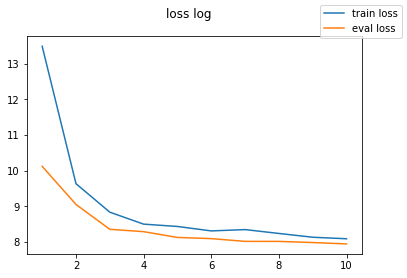

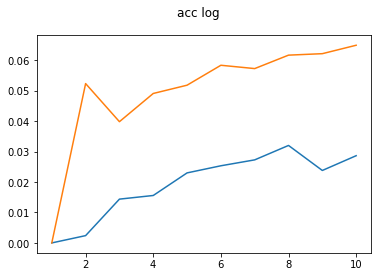

In [6]:
batch_size = 292
udb_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True)
udb_test_loader = DataLoader(udb_test_set, batch_size=batch_size)
# db_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True)
# db_test_loader = DataLoader(udb_test_set, batch_size=batch_size)
train(True, udb_train_loader, udb_test_loader, 'udb')

# DataLoader改善

In [1]:
import os
os.cpu_count()

16

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import gensim
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

isModeling = True
num_experiment = 100
num_epoch = 100
LSTM_hidden_dim = 128
LSTM_num_layer = 3
dropout_rate = 0.3
lr = 0.05
batch_size = 292

# data loaderのため
torch.manual_seed(0)

os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)

if not os.path.isdir('.data'):
    os.mkdir('.data')
if not os.path.isdir('figs'):
    os.mkdir('figs')

print('preparing data')
w2v_undebiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
w2v_debiased = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-hard-debiased.bin', binary=True)
w2v_dim = 300

with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    data_dict = json.load(f)

max_words_context = 0
max_words_question = 0
data_idxs = []
for i, title in enumerate(data_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        num_words_context = len(word_tokenize(paragraph['context'].lower()))
        if num_words_context > max_words_context:
            max_words_context = num_words_context
        for k, qa in enumerate(paragraph['qas']):
            data_idxs.append(str(i)+'-'+str(j)+'-'+str(k))
            num_words_question = len(word_tokenize(qa['question'].lower()))
            if num_words_question > max_words_question:
                max_words_question = num_words_question
train_idxs, test_idxs = train_test_split(data_idxs, test_size=0.2, random_state=0)

class MyDataset(Dataset):
    def __init__(self,
                 data_dict, index_lst,
                 max_words_context, max_words_question, w2v_dim,
                 w2v_model):
        self.data_dict = data_dict
        self.index_lst = index_lst
        self.num_data = len(index_lst)
        self.max_words_context = max_words_context
        self.max_words_question = max_words_question
        self.w2v_dim = w2v_dim
        self.w2v_model = w2v_model

    def __len__(self):
        return self.num_data

    def __getitem__(self, i):
        idx = list(map(lambda x: int(x), self.index_lst[i].split('-')))
        context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
        context = word_tokenize(context.lower())
        context_emb = torch.zeros(self.max_words_context, self.w2v_dim)
        for i, word in enumerate(context):
            if word in self.w2v_model.key_to_index:
                context_emb[i] += self.w2v_model[word]
        question = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['question']
        question = word_tokenize(question.lower())
        question_emb = torch.zeros(self.max_words_question, self.w2v_dim)
        for i, word in enumerate(question):
            if word in self.w2v_model.key_to_index:
                question_emb[i] += self.w2v_model[word]
        answer = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['qas'][idx[2]]['answers'][0]
        context = self.data_dict['data'][idx[0]]['paragraphs'][idx[1]]['context']
        context = context[:answer['answer_start']] + ' _start_point_ ' + context[answer['answer_start']:]
        context = word_tokenize(context.lower())
        start_idx = context.index('_start_point_')
        end_idx = start_idx + len(word_tokenize(answer['text'])) - 1
        return context_emb, question_emb, start_idx, end_idx

# 入力：文書と質問(バッチ数x単語数x分散表現の次元)
# 出力：文書の中で答えと予想される範囲の始まりと終わりの分布(バッチ数x単語数)
class DocReader(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, dropout):
        super(DocReader, self).__init__()
        self.P_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_Enc = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layer,
            dropout=dropout, bidirectional=True,
            batch_first=True
        )
        self.Q_AccumWeight = nn.Linear(hidden_dim*2, 1, bias=False)
        self.Start_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)
        self.End_Pred = nn.Linear(hidden_dim*2, hidden_dim*2, bias=False)

    def forward(self, p, q):
        p, _ = self.P_Enc(p)
        q, _ = self.Q_Enc(q)
        b = F.softmax(self.Q_AccumWeight(q), dim=1)
        q = (q*b).sum(dim=1)
        pred_start = torch.einsum('bnm,bm->bn', self.Start_Pred(p), q)
        pred_end = torch.einsum('bnm,bm->bn', self.End_Pred(p), q)
        return pred_start, pred_end

def eval_exact_match(pred_start, pred_end, y_start, y_end):
    pred_start = pred_start.max(dim=1).indices
    pred_end = pred_end.max(dim=1).indices
    match = torch.logical_and(pred_start==y_start, pred_end==y_end)
    return match.sum() / len(match)

def eval_f1(pred_start, pred_end, y_start, y_end):
    pred_start = pred_start.max(dim=1).indices
    pred_end = pred_end.max(dim=1).indices
    start_diff = pred_start - y_start
    start_diff = torch.where(start_diff > 0, start_diff, 0)
    end_diff = y_end - pred_end
    end_diff = torch.where(end_diff > 0, end_diff, 0)
    TP = (y_end - y_start + 1 - start_diff - end_diff).double()
    TP = torch.where(TP > 0, TP, 1e-10) # TP=0だとf1がnanになる
    recall = TP / (y_end - y_start + 1)
    pred_diff = pred_end - pred_start
    pred_diff = torch.where(pred_diff > 0, pred_diff, 0)
    precision = TP / (pred_diff + 1)
    f1 = 2*recall*precision / (recall + precision)
    return f1.mean()

C:\Users\gabriel\anaconda3\envs\torch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


device: cuda
preparing data


In [2]:
def train(isModeling, train_loader, test_loader, representation):
    
    time0 = time.time()
    
    print('{} model'.format(representation))
    num_experiment = 1
    for experiment in range(num_experiment):
        model = DocReader(w2v_dim, LSTM_hidden_dim, LSTM_num_layer, dropout_rate).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

        time1 = time.time()
        print('prepare:{:.2}'.format(time1 - time0))
        print()

        for epoch in range(num_epoch):
            model.train()
            train_loss = 0
            
            time0 = time.time()
            
            for X_context, X_question, y_start, y_end in train_loader:
                
                time1 = time.time()
                print('data loading:{:.2}'.format(time1 - time0))
                
                X_context = X_context.to(device)
                X_question = X_question.to(device)
                y_start = y_start.to(device)
                y_end = y_end.to(device)
                
                time2 = time.time()
                print('data moving:{:.2}'.format(time2 - time1))
                
                pred_start, pred_end = model(X_context, X_question)
                
                time3 = time.time()
                print('predicting:{:.2}'.format(time3 - time2))
                
                loss = loss_fn(pred_start, y_start) + loss_fn(pred_end, y_end)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss*len(y_start)
                
                time4 = time.time()
                print('backwarding:{:.2}'.format(time4 - time3))
                print()
                
                time0 = time.time()

            train_loss /= len(train_idxs)

            model.eval()
            eval_loss = 0
            em_total = 0
            f1_total = 0
            with torch.no_grad():
                
                time0 = time.time()
                
                for X_context, X_question, y_start, y_end in test_loader:
                    
                    time1 = time.time()
                    print('data loading:{:.2}'.format(time1 - time0))
                    
                    X_context = X_context.to(device)
                    X_question = X_question.to(device)
                    y_start = y_start.to(device)
                    y_end = y_end.to(device)
                    
                    time2 = time.time()
                    print('data moving:{:.2}'.format(time2 - time1))
                    
                    pred_start, pred_end = model(X_context, X_question)
                    
                    time3 = time.time()
                    print('predicting:{:.2}'.format(time3 - time2))
                    
                    loss = loss_fn(pred_start, y_start) + loss_fn(pred_end, y_end)
                    eval_loss += loss
                    em = eval_exact_match(pred_start, pred_end, y_start, y_end)
                    em_total += em
                    f1 = eval_f1(pred_start, pred_end, y_start, y_end)
                    f1_total += f1
                    
                    time4 = time.time()
                    print('evaluating:{:.2}'.format(time4 - time3))
                    print()
                    
                eval_loss /= len(test_loader)
                em_total /= len(test_loader)
                f1_total /= len(test_loader)
    if isModeling:
        return None
    else:
        return em_scores, f1_scores

In [ ]:
num_epoch = 1
num_workers = 0
udb_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
udb_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
db_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)
db_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)
udb_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
udb_test_loader = DataLoader(udb_test_set, batch_size=batch_size, num_workers=num_workers)
db_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
db_test_loader = DataLoader(udb_test_set, batch_size=batch_size, num_workers=num_workers)
udb_result = train(isModeling, udb_train_loader, udb_test_loader, 'udb')
db_result = train(isModeling, db_train_loader, db_test_loader, 'db')

In [ ]:
num_epoch = 1
num_workers = 2
udb_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
udb_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_undebiased)
db_train_set = MyDataset(data_dict, train_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)
db_test_set = MyDataset(data_dict, test_idxs, max_words_context, max_words_question, w2v_dim, w2v_debiased)
udb_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
udb_test_loader = DataLoader(udb_test_set, batch_size=batch_size, num_workers=num_workers)
db_train_loader = DataLoader(udb_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
db_test_loader = DataLoader(udb_test_set, batch_size=batch_size, num_workers=num_workers)
udb_result = train(isModeling, udb_train_loader, udb_test_loader, 'udb')
db_result = train(isModeling, db_train_loader, db_test_loader, 'db')

udb model
prepare:3.8



In [3]:
import torch
context = torch.zeros(18896, 707, 300, dtype=float)
question = torch.zeros(87599, 43, 30, dtype=float)

In [4]:
80521000800 / (1024*1024*1024)

74.991025775671

In [10]:
import json
with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    data_dict = json.load(f)
count = 0
for i, title in enumerate(data_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        count += 1
count

18896

In [1]:
import json
from nltk.tokenize import word_tokenize
with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    data_dict = json.load(f)
max_words_context = 0
max_words_question = 0
for i, title in enumerate(data_dict['data']):
    for j, paragraph in enumerate(title['paragraphs']):
        context = word_tokenize(paragraph['context'].lower())
        context = [word for word in context if word not in [',', '.']]
        num_words_context = len(context)
        if num_words_context > max_words_context:
            max_words_context = num_words_context
        for k, qa in enumerate(paragraph['qas']):
            question = word_tokenize(qa['question'].lower())
            question = [word for word in question if word not in [',', '.']]
            num_words_question = len(question)
            if num_words_question > max_words_question:
                max_words_question = num_words_question

In [2]:
print(max_words_context, max_words_question)

707 43


# データの準備, モデルの作成

In [25]:
import json
import gensim
from nltk.tokenize import word_tokenize, sent_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
task = 'undebiased'
w2v_dim = 300

In [3]:
with open('data/squad1.1/train-v1.1.json', encoding='utf-8') as f:
    data_dict = json.load(f)
if task == 'undebiased':
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(
        './data/GoogleNews-vectors-negative300.bin', binary=True
    )
elif task == 'debiased':
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(
        './data/GoogleNews-vectors-negative300-hard-debiased.bin', binary=True
    )

In [4]:
max_num_sentence = 0
num_context = 0
num_question = 0
for title in data_dict['data']:
    for paragraph in title['paragraphs']:
        num_context += 1
        num_sentence = len(sent_tokenize(paragraph['context']))
        if num_sentence > max_num_sentence:
            max_num_sentence = num_sentence
        for qa in paragraph['qas']:
            num_question += 1

In [35]:
print(max_num_sentence, num_context, num_question)

27 18896 87599


In [65]:
87599*0.8

70079.2

In [5]:
questions = torch.zeros(num_question, 300)
contexts = torch.zeros(num_context, max_num_sentence, 300)
context_idxs = []
answers = []
context_id = 0
question_id = 0
for title in data_dict['data']:
    for paragraph in title['paragraphs']:
        sentences = sent_tokenize(paragraph['context'])
        for i, sentence in enumerate(sentences):
            words = [word for word in word_tokenize(sentence.lower()) if word in w2v_model.key_to_index]
            if len(words) > 0:
                contexts[context_id, i] += w2v_model[words].mean(axis=0)
            else:
                contexts[context_id, i] += torch.zeros(300)
        context_id += 1
        for qa in paragraph['qas']:
            questions[question_id] += w2v_model[[word for word in word_tokenize(qa['question'].lower()) if word in w2v_model.key_to_index]].mean(axis=0)
            question_id += 1
            answer = qa['answers'][0]
            context = paragraph['context']
            context = context[:answer['answer_start']] + '_answer_tag_' + context[answer['answer_start']:]
            sentences = sent_tokenize(context)
            for sentence in sentences:
                if '_answer_tag_' in sentence:
                    answers.append(sentences.index(sentence))
            context_idxs.append(context_id)

In [54]:
question = questions[:5]
context = torch.stack([contexts[i] for i in context_idxs[:5]])

In [62]:
class QAModel2(nn.Module):
    def __init__(self, w2v_dim, hid1, hid2, hid3, num_sentence):
        super(QAModel2, self).__init__()
        self.ln1 = nn.Linear(w2v_dim*2, hid1)
        self.ln2 = nn.Linear(hid1, hid2)
        self.ln3 = nn.Linear(hid2, hid3)
        self.ln4 = nn.Linear(hid3, 1)
        self.num_sentence = num_sentence
    
    def forward(self, q, s, batch_size):
        print(q.shape, s.shape)
        q = torch.stack([q for _ in range(self.num_sentence)], dim=1)
        print(q.shape, s.shape)
        x = torch.cat((q, s), dim=2)
        print(x.shape)
        x = self.ln1(x)
        print(x.shape)
        x = F.relu(x)
        x = self.ln2(x)
        print(x.shape)
        x = F.relu(x)
        x = self.ln3(x)
        print(x.shape)
        x = F.relu(x)
        x = self.ln4(x)
        print(x.shape)
        x = x.view(batch_size, -1)
        print(x.shape)
        return x

In [63]:
model = QAModel2(300, 300, 100, 10, max_num_sentence)
model(question, context, 5)

torch.Size([5, 300]) torch.Size([5, 27, 300])
torch.Size([5, 27, 300]) torch.Size([5, 27, 300])
torch.Size([5, 27, 600])
torch.Size([5, 27, 300])
torch.Size([5, 27, 100])
torch.Size([5, 27, 10])
torch.Size([5, 27, 1])
torch.Size([5, 27])


tensor([[-0.2680, -0.2677, -0.2679, -0.2679, -0.2662, -0.2680, -0.2680, -0.2681,
         -0.2683, -0.2685, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683,
         -0.2683, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683,
         -0.2683, -0.2683, -0.2683],
        [-0.2674, -0.2667, -0.2672, -0.2672, -0.2652, -0.2674, -0.2673, -0.2675,
         -0.2676, -0.2678, -0.2678, -0.2673, -0.2673, -0.2673, -0.2673, -0.2673,
         -0.2673, -0.2673, -0.2673, -0.2673, -0.2673, -0.2673, -0.2673, -0.2673,
         -0.2673, -0.2673, -0.2673],
        [-0.2667, -0.2657, -0.2661, -0.2666, -0.2639, -0.2665, -0.2663, -0.2666,
         -0.2669, -0.2671, -0.2668, -0.2665, -0.2665, -0.2665, -0.2665, -0.2665,
         -0.2665, -0.2665, -0.2665, -0.2665, -0.2665, -0.2665, -0.2665, -0.2665,
         -0.2665, -0.2665, -0.2665],
        [-0.2666, -0.2658, -0.2663, -0.2666, -0.2646, -0.2670, -0.2664, -0.2666,
         -0.2670, -0.2670, -0.2672, -0.2664, -0.2664, -0.2664, -0.2664, -0.2664

In [32]:
class QAModel1(nn.Module):
    def __init__(self, w2v_dim, hid1, hid2, num_sentence, hid3):
        super(QAModel1, self).__init__()
        self.QEnc1 = nn.Linear(w2v_dim, hid1)
        self.QEnc2 = nn.Linear(hid1, hid2)
        self.SEnc1 = nn.Linear(w2v_dim, hid1)
        self.SEnc2 = nn.Linear(hid1, hid2)
        self.Classifier1 = nn.Linear(hid2*(1+num_sentence), hid3)
        self.Classifier2 = nn.Linear(hid3, num_sentence)
    
    def forward(self, q, s, batch_size):
        print(q.shape, s.shape)
        q = self.QEnc1(q)
        print(q.shape, s.shape)
        q = F.relu(q)
        q = self.QEnc2(q)
        print(q.shape, s.shape)
        s = self.SEnc1(s)
        print(q.shape, s.shape)
        s = F.relu(s)
        s = self.SEnc2(s)
        print(q.shape, s.shape)
        x = torch.cat((q, s.view(batch_size, -1)), dim=1)
        print(x.shape)
        x = self.Classifier1(x)
        print(x.shape)
        x = F.relu(x)
        x = self.Classifier2(x)
        print(x.shape)
        return x

In [33]:
model = QAModel1(300, 100, 10, max_num_sentence, 100)
model(question, context, 5)

torch.Size([5, 300]) torch.Size([5, 27, 300])
torch.Size([5, 100]) torch.Size([5, 27, 300])
torch.Size([5, 10]) torch.Size([5, 27, 300])
torch.Size([5, 10]) torch.Size([5, 27, 100])
torch.Size([5, 10]) torch.Size([5, 27, 10])
torch.Size([5, 280])
torch.Size([5, 100])
torch.Size([5, 27])


tensor([[-0.0701,  0.0847,  0.0458, -0.0125,  0.1104,  0.0637,  0.0051,  0.0331,
         -0.0656,  0.0537,  0.0745,  0.0616,  0.0126,  0.0492, -0.1082, -0.0651,
          0.0232, -0.0216, -0.0901,  0.0786, -0.0518,  0.0276, -0.0202,  0.0520,
          0.0231,  0.0904, -0.0598],
        [-0.0705,  0.0853,  0.0458, -0.0125,  0.1107,  0.0636,  0.0055,  0.0326,
         -0.0656,  0.0540,  0.0747,  0.0629,  0.0126,  0.0499, -0.1085, -0.0654,
          0.0237, -0.0211, -0.0894,  0.0795, -0.0539,  0.0276, -0.0189,  0.0520,
          0.0224,  0.0905, -0.0603],
        [-0.0710,  0.0853,  0.0463, -0.0128,  0.1106,  0.0632,  0.0051,  0.0326,
         -0.0659,  0.0538,  0.0750,  0.0631,  0.0126,  0.0495, -0.1082, -0.0655,
          0.0232, -0.0210, -0.0895,  0.0792, -0.0527,  0.0281, -0.0195,  0.0521,
          0.0225,  0.0904, -0.0604],
        [-0.0710,  0.0853,  0.0462, -0.0126,  0.1109,  0.0631,  0.0052,  0.0326,
         -0.0662,  0.0538,  0.0752,  0.0634,  0.0127,  0.0499, -0.1082, -0.0654

In [15]:
lst = ['this', 'is', 'a', 'pen', '.']
w2v_model[[word for word in lst if word in w2v_model.key_to_index]].mean(axis=0).shape

(300,)

In [29]:
lst = ['aaa', 'bbb', 'ccc']
lst.index('aaa')

0

In [44]:
tmp = torch.randn(3,5)
ln = torch.nn.Linear(5,4)
ln(tmp)

tensor([[-0.0064, -0.6183, -0.1550,  0.4980],
        [-0.5288,  0.6372,  0.0337, -0.1819],
        [ 0.6930, -0.7820, -0.1539,  0.7243]], grad_fn=<AddmmBackward>)

In [45]:
tmp = torch.randn(5)
ln = torch.nn.Linear(5,4)
ln(tmp)

tensor([ 0.0498,  0.2941, -0.0307,  0.3501], grad_fn=<AddBackward0>)

In [58]:
tmp = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
tmp_ = torch.tensor([7.,8.,9.])
ln = torch.nn.Linear(3,2)
print(ln(tmp))
print(ln(tmp).view(-1, 1))
print(torch.cat((ln(tmp).view(-1), tmp_), dim=0))

tensor([[-0.8205, -2.3091],
        [-1.6800, -4.5780]], grad_fn=<AddmmBackward>)
tensor([[-0.8205],
        [-2.3091],
        [-1.6800],
        [-4.5780]], grad_fn=<ViewBackward>)
tensor([-0.8205, -2.3091, -1.6800, -4.5780,  7.0000,  8.0000,  9.0000],
       grad_fn=<CatBackward>)


In [65]:
tmp = torch.randn(2,3,4)
print(tmp)
print(tmp.reshape(2, -1))

tensor([[[-0.4548,  0.4365,  1.5742, -0.4050],
         [-0.2412, -1.0823, -0.5030, -0.1549],
         [-0.2878, -0.3213, -0.2747, -0.3449]],

        [[ 0.4737,  0.2805,  0.3462,  0.5088],
         [-0.8210,  1.9877,  0.3140,  2.5739],
         [-0.2093, -0.8281, -0.2384, -0.9966]]])
tensor([[-0.4548,  0.4365,  1.5742, -0.4050, -0.2412, -1.0823, -0.5030, -0.1549,
         -0.2878, -0.3213, -0.2747, -0.3449],
        [ 0.4737,  0.2805,  0.3462,  0.5088, -0.8210,  1.9877,  0.3140,  2.5739,
         -0.2093, -0.8281, -0.2384, -0.9966]])


In [67]:
tmp1 = torch.randn(2,3)
tmp2 = torch.randn(2,3)
torch.cat((tmp1, tmp2), dim=1)

tensor([[ 0.3788,  1.4626, -1.4232,  0.7177,  0.8226,  1.7125],
        [ 0.2577,  0.3597, -0.5616,  0.0729,  0.4379, -1.1221]])

In [46]:
tmp = torch.randn(3,5)
tmp = torch.stack([tmp for i in range(4)], dim=1)
tmp

tensor([[[ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771]],

        [[-0.1283, -0.0267, -0.1863,  0.6343, -0.4826],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826]],

        [[ 0.3379,  0.2892,  0.7654, -0.0264, -1.0259],
         [ 0.3379,  0.2892,  0.7654, -0.0264, -1.0259],
         [ 0.3379,  0.2892,  0.7654, -0.0264, -1.0259],
         [ 0.3379,  0.2892,  0.7654, -0.0264, -1.0259]]])

In [47]:
tmp_ = torch.randn(3,4,5)
tmp_

tensor([[[ 1.1476,  0.8880,  0.4228, -1.4989, -0.6753],
         [-1.9026, -0.1777,  1.5500,  1.3007,  0.6102],
         [ 1.8626, -0.3656,  0.7621,  1.8038, -0.9714],
         [-0.2793, -0.0034,  0.2644, -0.9639, -0.6296]],

        [[-1.5686,  0.7946, -0.1522,  0.4611,  2.0914],
         [ 0.6665,  0.0947, -0.2189,  0.1624,  1.6970],
         [ 0.0466, -0.2103,  0.2228,  0.4168,  0.6527],
         [ 0.2106, -0.1313,  0.7137, -0.3999, -1.2237]],

        [[-1.0784,  0.6409, -0.4571,  0.7020,  1.0462],
         [ 0.3668, -0.1541,  1.1270,  0.7282,  0.0456],
         [ 2.7532,  0.1541,  0.5247,  1.1851, -0.8798],
         [ 0.5988, -1.5035, -3.3389,  0.4964,  0.5917]]])

In [52]:
torch.cat((tmp, tmp_), dim=2)

tensor([[[ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771,  1.1476,  0.8880,
           0.4228, -1.4989, -0.6753],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771, -1.9026, -0.1777,
           1.5500,  1.3007,  0.6102],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771,  1.8626, -0.3656,
           0.7621,  1.8038, -0.9714],
         [ 1.0267,  1.0830,  1.6508, -0.2290, -0.2771, -0.2793, -0.0034,
           0.2644, -0.9639, -0.6296]],

        [[-0.1283, -0.0267, -0.1863,  0.6343, -0.4826, -1.5686,  0.7946,
          -0.1522,  0.4611,  2.0914],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826,  0.6665,  0.0947,
          -0.2189,  0.1624,  1.6970],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826,  0.0466, -0.2103,
           0.2228,  0.4168,  0.6527],
         [-0.1283, -0.0267, -0.1863,  0.6343, -0.4826,  0.2106, -0.1313,
           0.7137, -0.3999, -1.2237]],

        [[ 0.3379,  0.2892,  0.7654, -0.0264, -1.0259, -1.0784,  0.6409,
          -0.4571,  0.7020,  1.0462

In [1]:
import pandas as pd
task = 'undebiased'
df = pd.read_csv('outputs/QA_label_index_{}.csv'.format(task))
answers = list(df['answers'])
context_idxs = list(df['context_idxs'])